In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from IPython.display import display


In [2]:
raw = pd.DataFrame.from_csv('mean-stdev-raw.csv')
norm = pd.DataFrame.from_csv('mean-stdev-norm.csv')
intra = pd.DataFrame.from_csv('mean-stdev-intra.csv')
inter = pd.DataFrame.from_csv('mean-stdev-inter.csv')

tags = np.array(['P'] * 10 + ['S'] * 10)
labels = ['P', 'S']
dfs = [raw, norm, intra, inter]
colors = ['darkorange', 'r']

features = pd.concat(dfs, axis = 1)


In [3]:
def calcAndPlotROCCurve(ax, data, tags, trueLabel, color, title = ''):
    fpr, tpr, thresholds = metrics.roc_curve(tags, data, pos_label = trueLabel)
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, color = color, lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Random Guess')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve ' + title + ', True label = ' + trueLabel)
    ax.legend(loc='lower right')

def univariate1a(df):
    for colName in df.columns:
        fig, axs = plt.subplots(1, 2, figsize = (20,5))
        for i, ax in enumerate(axs):
            calcAndPlotROCCurve(ax, df[colName], tags, labels[i], colors[i], colName)
        plt.show()

def univariate1b(df):
    for colName in df.columns:
        sss = StratifiedShuffleSplit(n_splits = 1, test_size = 4)
        for cross_val_index, test_index in sss.split(df[colName], tags):
            X_cross_val, y_cross_val = df[colName].as_matrix()[cross_val_index], tags[cross_val_index]
            X_test, y_test = df[colName].as_matrix()[test_index], tags[test_index]

        sss = StratifiedShuffleSplit(n_splits = 50, test_size = 4)
        accuracy = []
        f1sP = []
        f1sS = []
        precisionsP = []
        precisionsS = []
        recallsP = []
        recallsS = []
        for train_index, val_index in sss.split(X_cross_val, y_cross_val):
            X_train, y_train = X_cross_val[train_index], y_cross_val[train_index]
            X_val, y_val = X_cross_val[val_index], y_cross_val[val_index]
            clf = LogisticRegression()
            clf.fit(X_train.reshape(-1, 1), y_train)
            predictions = clf.predict(X_val.reshape(-1, 1))
            accuracy.append(accuracy_score(y_val, predictions))
            f1sP.append(f1_score(y_val, predictions, pos_label = 'P'))
            f1sS.append(f1_score(y_val, predictions, pos_label = 'S'))
            precisionsP.append(precision_score(y_val, predictions, pos_label = 'P'))
            precisionsS.append(precision_score(y_val, predictions, pos_label = 'S'))
            recallsP.append(recall_score(y_val, predictions, pos_label = 'P'))
            recallsS.append(recall_score(y_val, predictions, pos_label = 'S'))

        clf = LogisticRegression()
        clf.fit(X_cross_val.reshape(-1, 1), y_cross_val)
        decision_function = clf.decision_function(X_test.reshape(-1, 1))
        predictions = clf.predict(X_test.reshape(-1, 1))

        dataDF = pd.DataFrame()
        dataDF = dataDF.append(pd.Series({'Mean': np.mean(accuracy), 'StDev': np.std(accuracy), 'Test': accuracy_score(y_test, predictions)}).rename('Accuracy'))
        dataDF = dataDF.append(pd.Series({'Mean': np.mean(f1sP), 'StDev': np.std(f1sP), 'Test': f1_score(y_test, predictions, pos_label = 'P')}).rename('F1 P'))
        dataDF = dataDF.append(pd.Series({'Mean': np.mean(f1sS), 'StDev': np.std(f1sS), 'Test': f1_score(y_test, predictions, pos_label = 'S')}).rename('F1 S'))
        dataDF = dataDF.append(pd.Series({'Mean': np.mean(precisionsP), 'StDev': np.std(precisionsP), 'Test': precision_score(y_test, predictions, pos_label = 'P')}).rename('Precision P'))
        dataDF = dataDF.append(pd.Series({'Mean': np.mean(precisionsS), 'StDev': np.std(precisionsS), 'Test': precision_score(y_test, predictions, pos_label = 'S')}).rename('Precision S'))
        dataDF = dataDF.append(pd.Series({'Mean': np.mean(recallsP), 'StDev': np.std(recallsP), 'Test': recall_score(y_test, predictions, pos_label = 'P')}).rename('Recall P'))
        dataDF = dataDF.append(pd.Series({'Mean': np.mean(recallsS), 'StDev': np.std(recallsS), 'Test': recall_score(y_test, predictions, pos_label = 'S')}).rename('Recall S'))
        display(dataDF.T)

        fig, axs = plt.subplots(1, 2, figsize = (20,5))
        for i, ax in enumerate(axs):
            calcAndPlotROCCurve(ax, decision_function, y_test, labels[i], colors[i], colName)
        plt.show()


In [4]:
def multivariate2a():
    sss = StratifiedShuffleSplit(n_splits = 1, test_size = 4)
    for cross_val_index, test_index in sss.split(features, tags):
        X_cross_val, y_cross_val = features.as_matrix()[cross_val_index], tags[cross_val_index]
        X_test, y_test = features.as_matrix()[test_index], tags[test_index]

    sss = StratifiedShuffleSplit(n_splits = 50, test_size = 4)
    accuracy = []
    f1sP = []
    f1sS = []
    precisionsP = []
    precisionsS = []
    recallsP = []
    recallsS = []
    for train_index, val_index in sss.split(X_cross_val, y_cross_val):
        X_train, y_train = X_cross_val[train_index], y_cross_val[train_index]
        X_val, y_val = X_cross_val[val_index], y_cross_val[val_index]
        clf = SVC()
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_val)
        accuracy.append(accuracy_score(y_val, predictions))
        f1sP.append(f1_score(y_val, predictions, pos_label = 'P'))
        f1sS.append(f1_score(y_val, predictions, pos_label = 'S'))
        precisionsP.append(precision_score(y_val, predictions, pos_label = 'P'))
        precisionsS.append(precision_score(y_val, predictions, pos_label = 'S'))
        recallsP.append(recall_score(y_val, predictions, pos_label = 'P'))
        recallsS.append(recall_score(y_val, predictions, pos_label = 'S'))

    clf = SVC()
    clf.fit(X_cross_val, y_cross_val)
    decision_function = clf.decision_function(X_test)
    predictions = clf.predict(X_test)

    dataDF = pd.DataFrame()
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(accuracy), 'StDev': np.std(accuracy), 'Test': accuracy_score(y_test, predictions)}).rename('Accuracy'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(f1sP), 'StDev': np.std(f1sP), 'Test': f1_score(y_test, predictions, pos_label = 'P')}).rename('F1 P'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(f1sS), 'StDev': np.std(f1sS), 'Test': f1_score(y_test, predictions, pos_label = 'S')}).rename('F1 S'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(precisionsP), 'StDev': np.std(precisionsP), 'Test': precision_score(y_test, predictions, pos_label = 'P')}).rename('Precision P'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(precisionsS), 'StDev': np.std(precisionsS), 'Test': precision_score(y_test, predictions, pos_label = 'S')}).rename('Precision S'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(recallsP), 'StDev': np.std(recallsP), 'Test': recall_score(y_test, predictions, pos_label = 'P')}).rename('Recall P'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(recallsS), 'StDev': np.std(recallsS), 'Test': recall_score(y_test, predictions, pos_label = 'S')}).rename('Recall S'))
    display(dataDF.T)

    fig, axs = plt.subplots(1, 2, figsize = (20,5))
    for i, ax in enumerate(axs):
        calcAndPlotROCCurve(ax, decision_function, y_test, labels[i], colors[i])
    plt.show()


In [5]:
def multivariate2b(percentile, kernel):
    sss = StratifiedShuffleSplit(n_splits = 1, test_size = 4)
    for cross_val_index, test_index in sss.split(features, tags):
        X_cross_val, y_cross_val = features.as_matrix()[cross_val_index], tags[cross_val_index]
        X_test, y_test = features.as_matrix()[test_index], tags[test_index]

    sss = StratifiedShuffleSplit(n_splits = 50, test_size = 4)
    accuracy = []
    f1sP = []
    f1sS = []
    precisionsP = []
    precisionsS = []
    recallsP = []
    recallsS = []
    for train_index, val_index in sss.split(X_cross_val, y_cross_val):
        X_train, y_train = X_cross_val[train_index], y_cross_val[train_index]
        X_val, y_val = X_cross_val[val_index], y_cross_val[val_index]

        ss = StandardScaler()
        fs = SelectPercentile(percentile = percentile)
        clf = SVC()
        steps = [('Standard Scaler', ss), ('Feature Selection', fs), ('SVM', clf)]
        pipe = Pipeline(steps)
        pipe.fit(X_train, y_train)

        predictions = pipe.predict(X_val)
        accuracy.append(accuracy_score(y_val, predictions))
        f1sP.append(f1_score(y_val, predictions, pos_label = 'P'))
        f1sS.append(f1_score(y_val, predictions, pos_label = 'S'))
        precisionsP.append(precision_score(y_val, predictions, pos_label = 'P'))
        precisionsS.append(precision_score(y_val, predictions, pos_label = 'S'))
        recallsP.append(recall_score(y_val, predictions, pos_label = 'P'))
        recallsS.append(recall_score(y_val, predictions, pos_label = 'S'))

    ss = StandardScaler()
    fs = SelectPercentile(percentile = percentile)
    clf = SVC(kernel = kernel)
    steps = [('Standard Scaler', ss), ('Feature Selection', fs), ('SVM', clf)]
    pipe = Pipeline(steps)
    pipe.fit(X_cross_val, y_cross_val)

    predictions = pipe.predict(X_test)
    decision_function = pipe.decision_function(X_test)

    dataDF = pd.DataFrame()
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(accuracy), 'StDev': np.std(accuracy), 'Test': accuracy_score(y_test, predictions)}).rename('Accuracy'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(f1sP), 'StDev': np.std(f1sP), 'Test': f1_score(y_test, predictions, pos_label = 'P')}).rename('F1 P'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(f1sS), 'StDev': np.std(f1sS), 'Test': f1_score(y_test, predictions, pos_label = 'S')}).rename('F1 S'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(precisionsP), 'StDev': np.std(precisionsP), 'Test': precision_score(y_test, predictions, pos_label = 'P')}).rename('Precision P'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(precisionsS), 'StDev': np.std(precisionsS), 'Test': precision_score(y_test, predictions, pos_label = 'S')}).rename('Precision S'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(recallsP), 'StDev': np.std(recallsP), 'Test': recall_score(y_test, predictions, pos_label = 'P')}).rename('Recall P'))
    dataDF = dataDF.append(pd.Series({'Mean': np.mean(recallsS), 'StDev': np.std(recallsS), 'Test': recall_score(y_test, predictions, pos_label = 'S')}).rename('Recall S'))
    display(dataDF.T)

    fig, axs = plt.subplots(1, 2, figsize = (20,5))
    for i, ax in enumerate(axs):
        calcAndPlotROCCurve(ax, decision_function, y_test, labels[i], colors[i])
    plt.show()


## Para cada feature, computar la curva ROC y graficarla

### Features: Mean and StDev para cada Banda de frecuencias para los datos desnormalizados

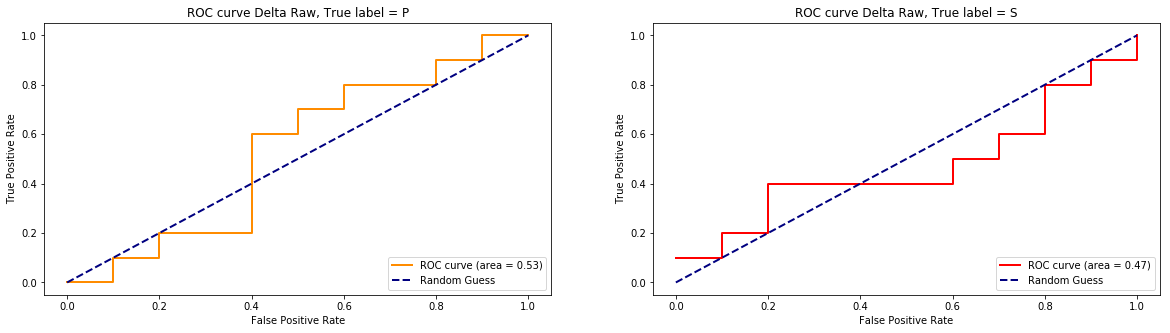

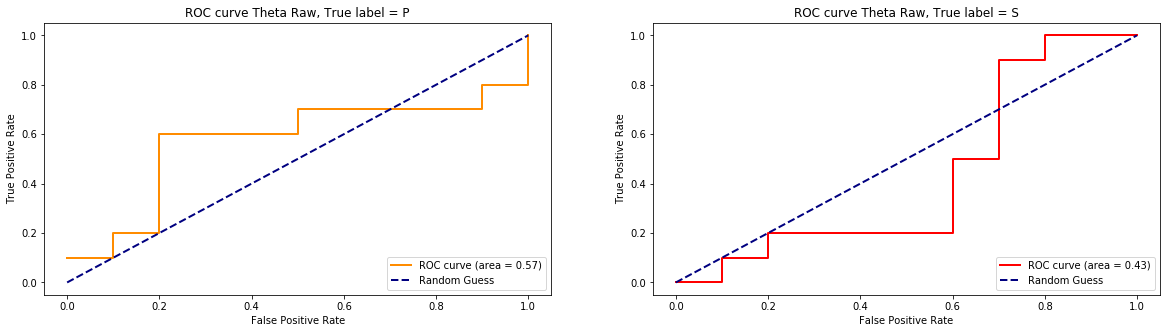

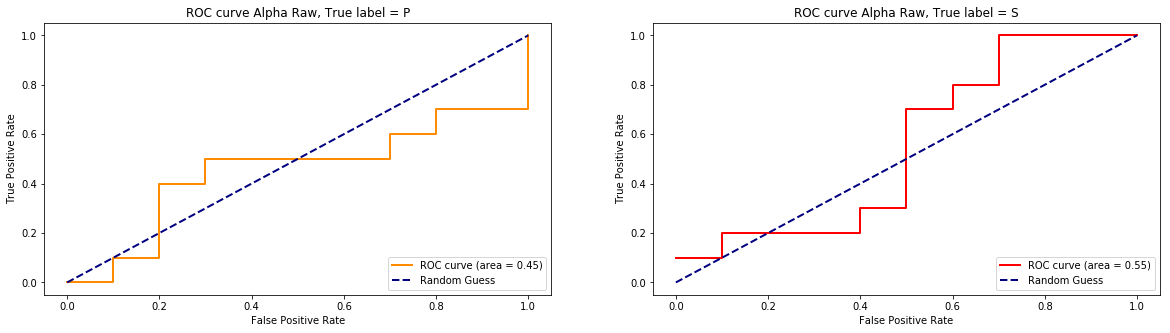

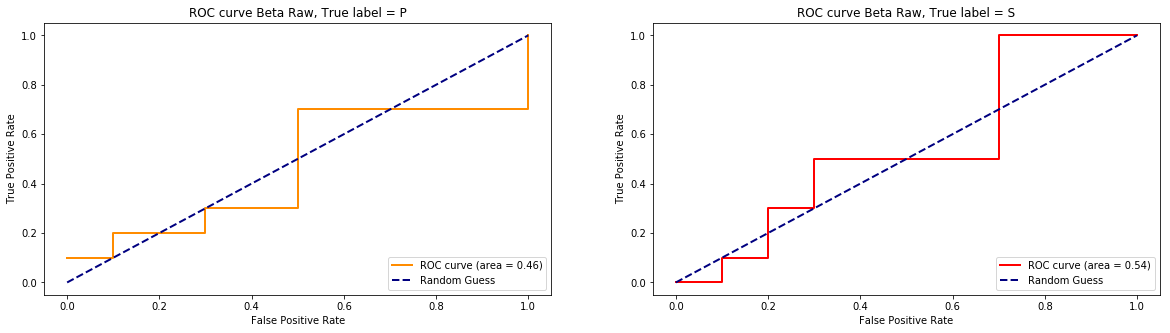

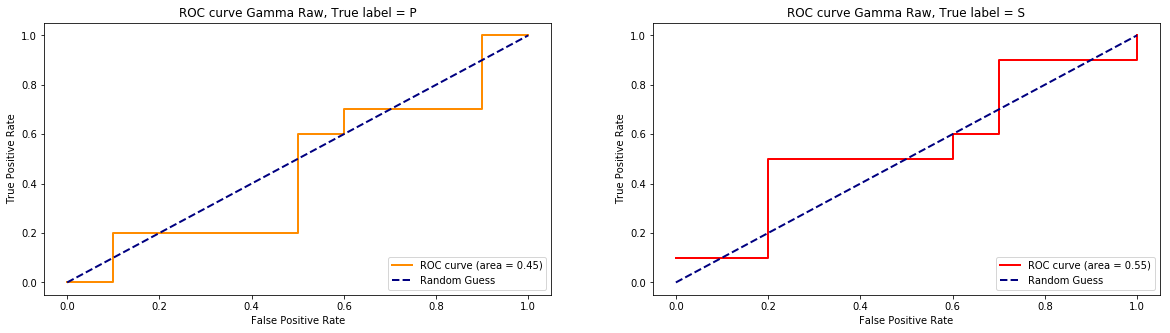

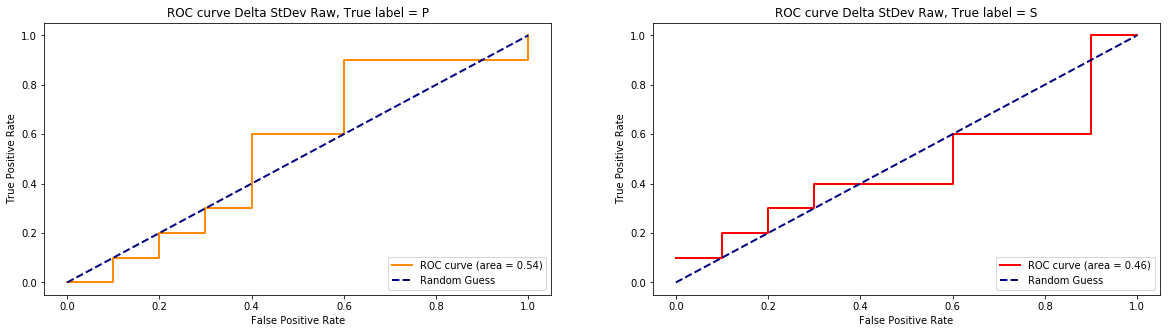

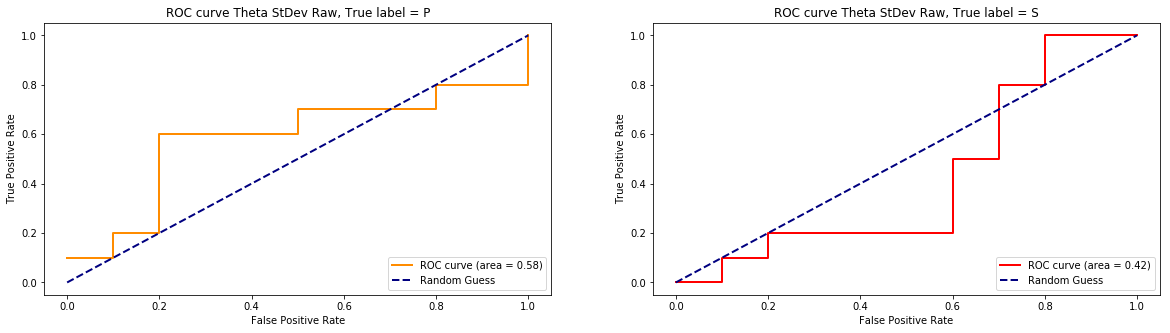

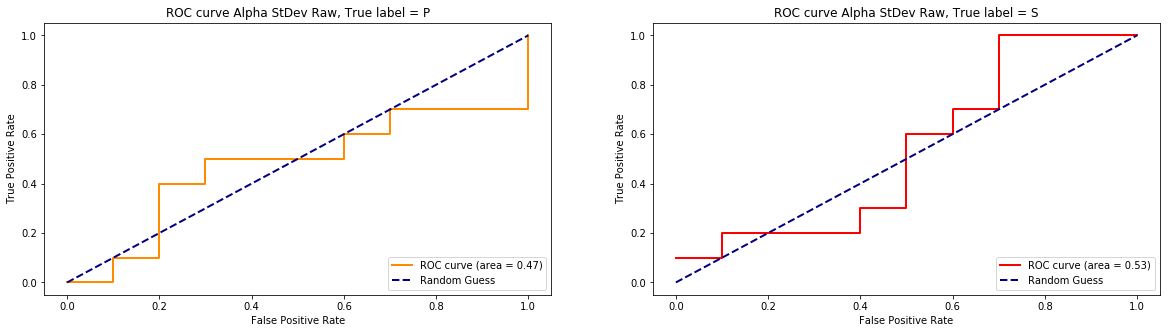

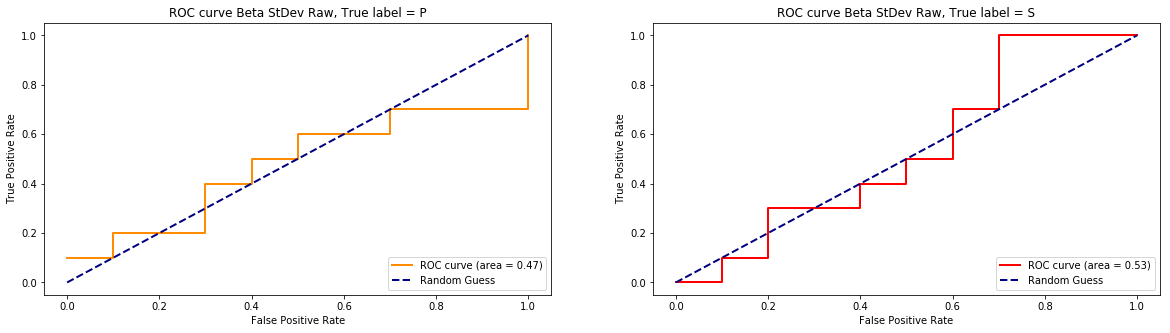

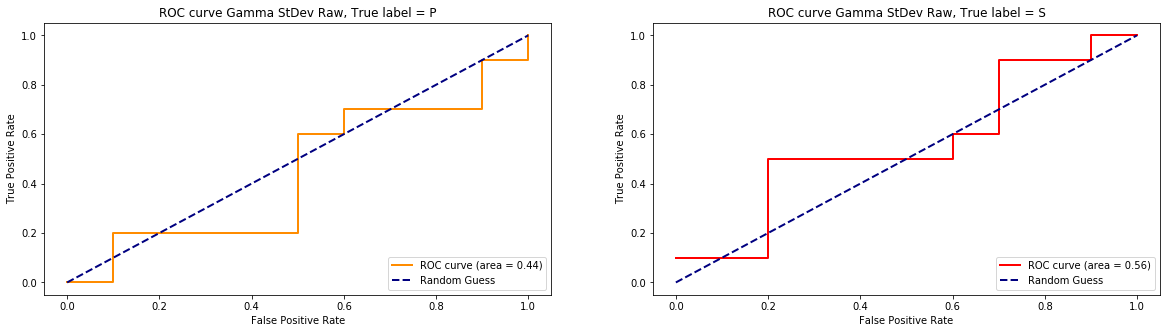

In [6]:
univariate1a(raw)


### Features: Mean and StDev para cada Banda de frecuencias para los datos normalizados

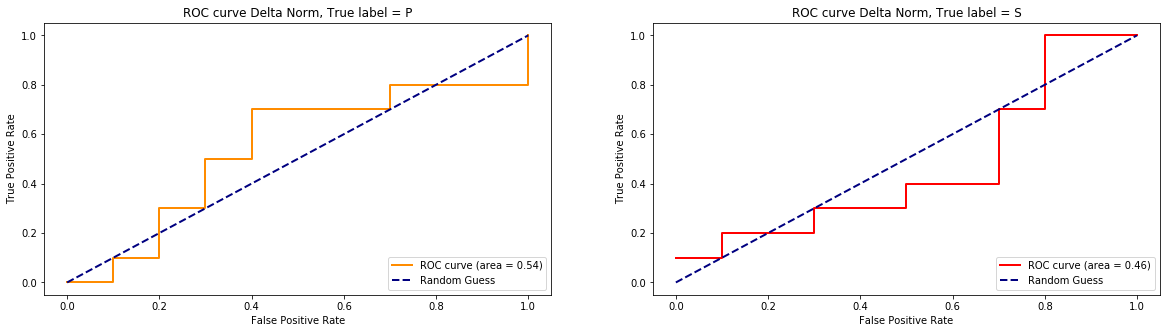

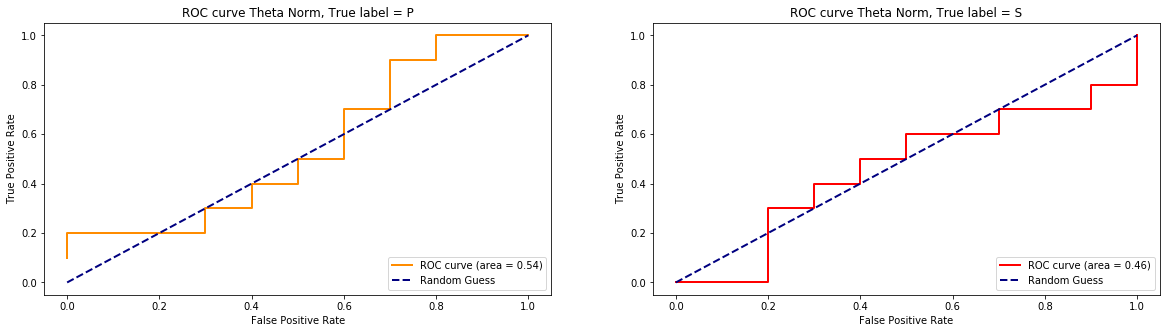

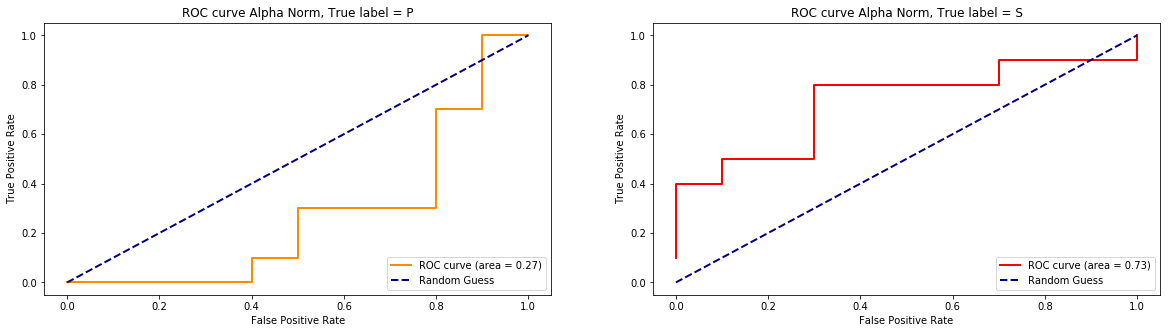

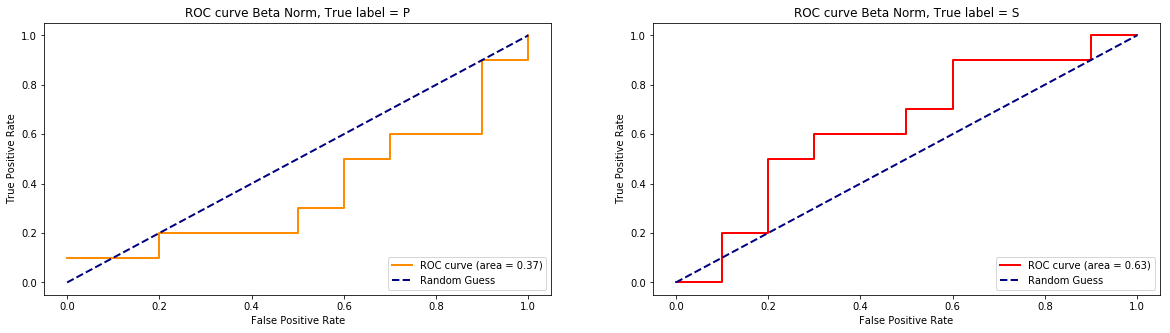

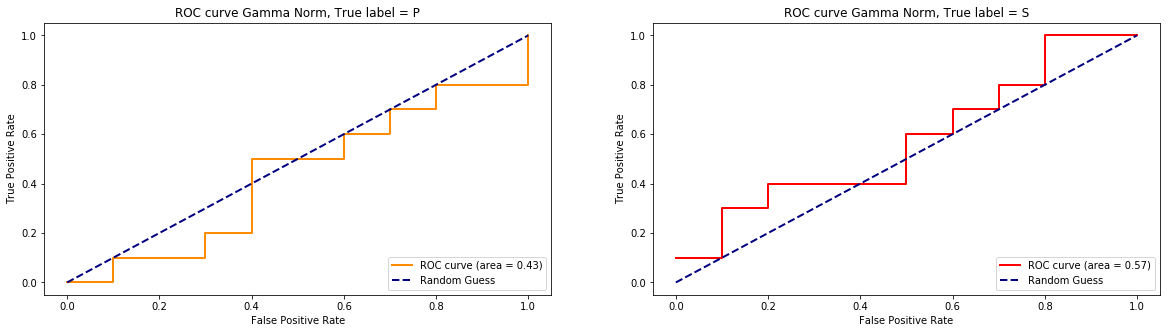

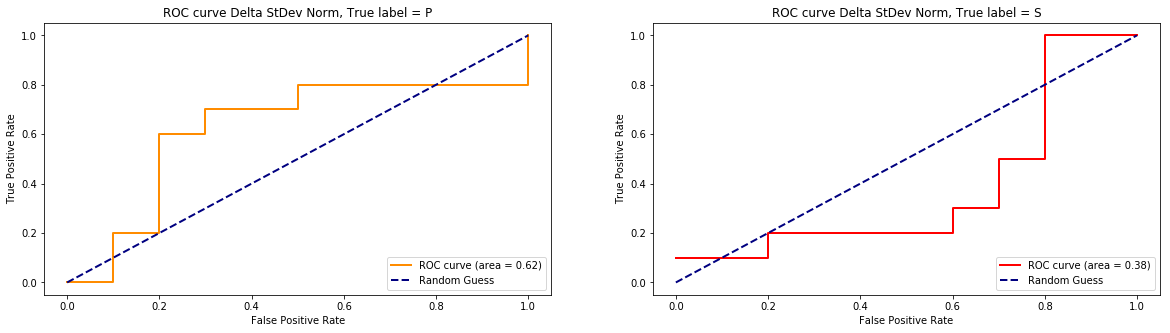

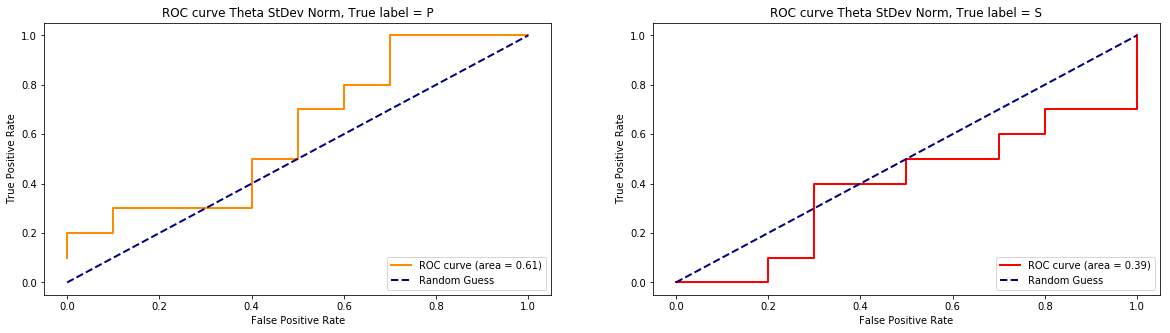

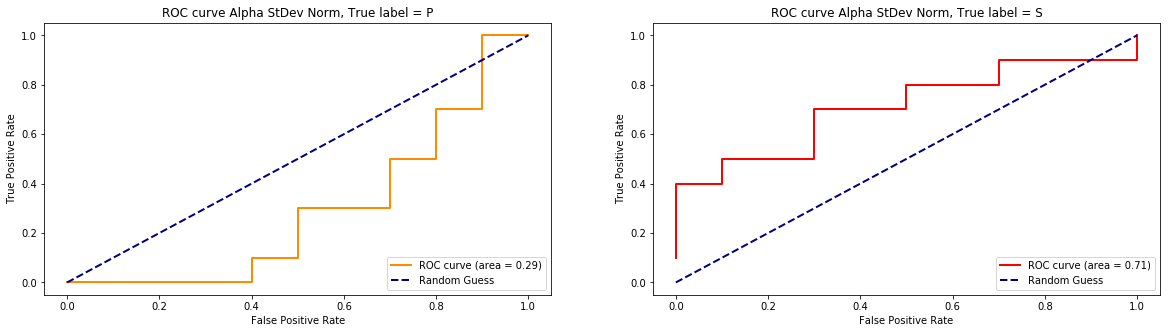

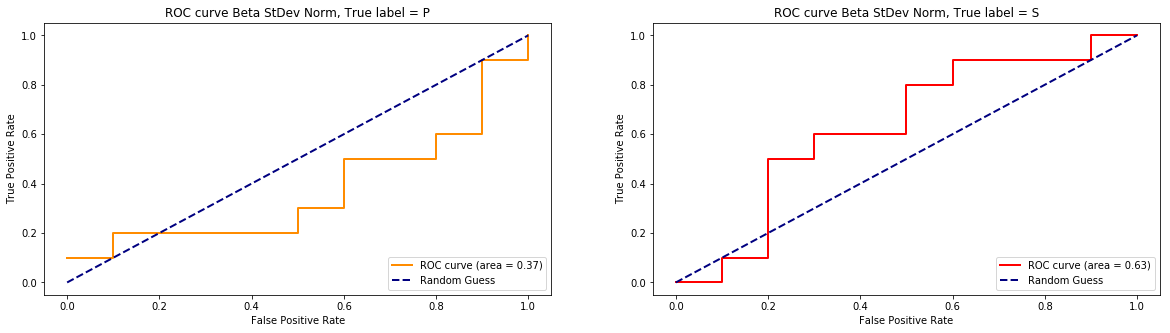

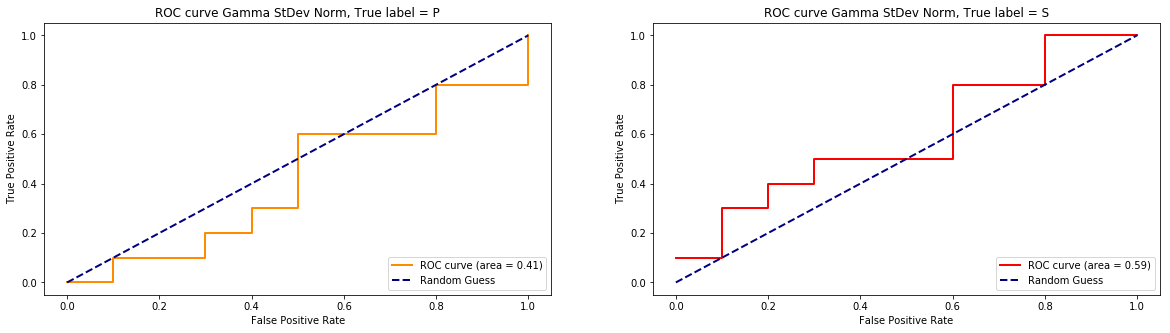

In [7]:
univariate1a(norm)


### Features: Mean and StDev para la medida intra-electrodo (entropía)

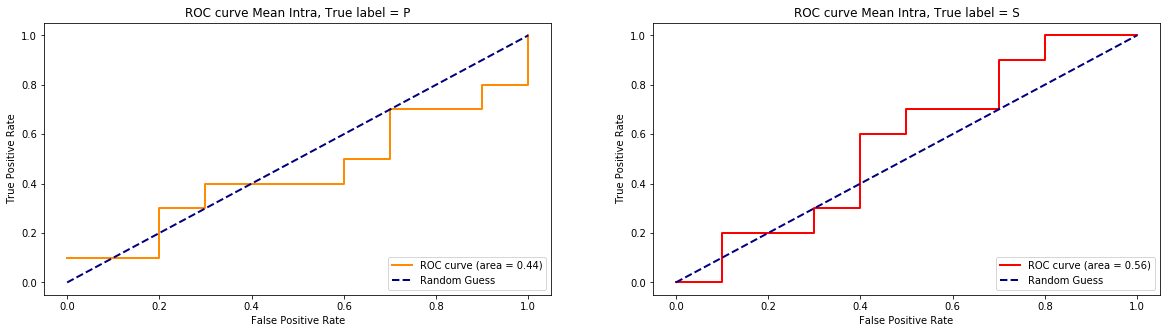

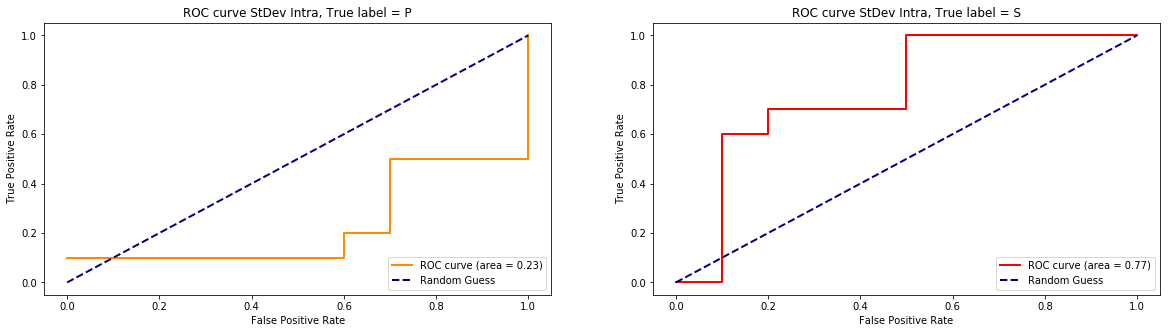

In [8]:
univariate1a(intra)


### Features: Mean and StDev para la medida inter-electrodo (entropía conjunta)

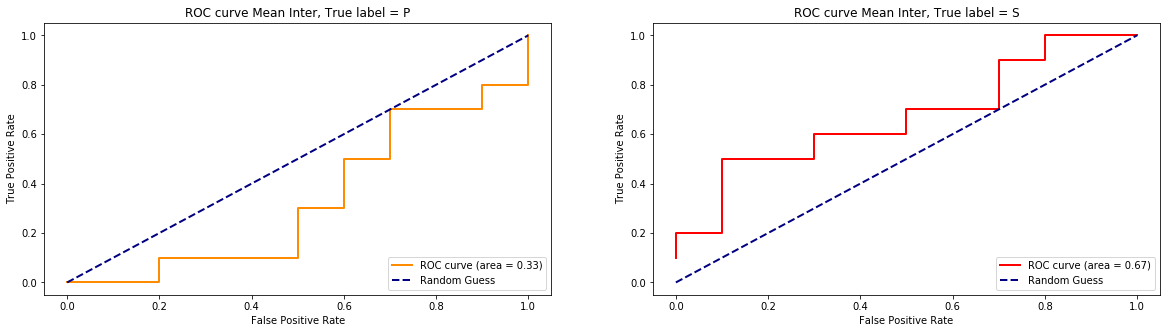

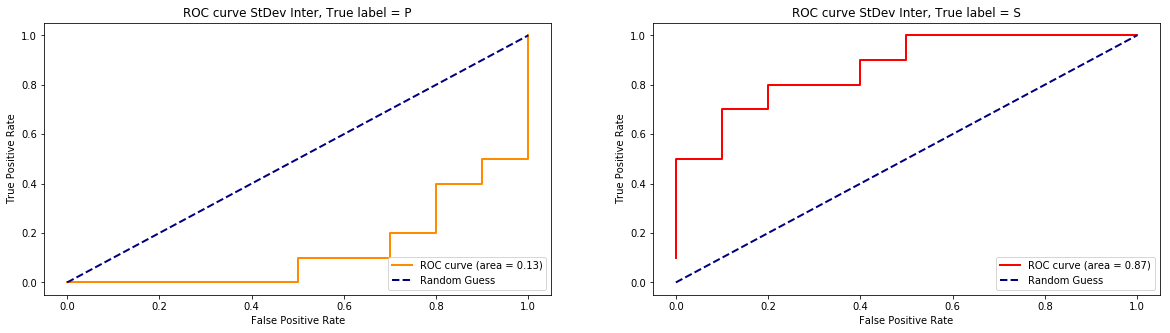

In [9]:
univariate1a(inter)


## Utilizando una técnica de cross validation, estimar la performance de un classificador Logistic Regression para cada feature y graficar la curva ROC correspondiente

### Features: Mean and StDev para cada Banda de frecuencias para los datos desnormalizados

/Users/personal/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/personal/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0
StDev,0.0,1.110223e-16,0.0,0.0,0.0,0.0,0.0
Test,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0


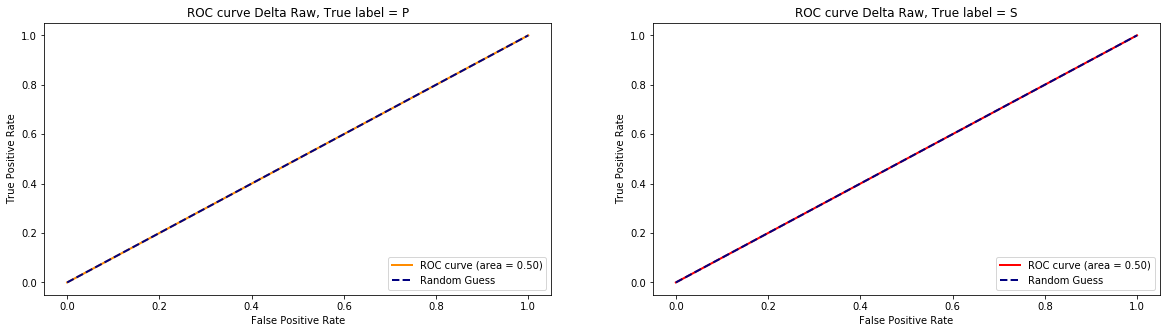

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0
StDev,0.0,1.110223e-16,0.0,0.0,0.0,0.0,0.0
Test,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0


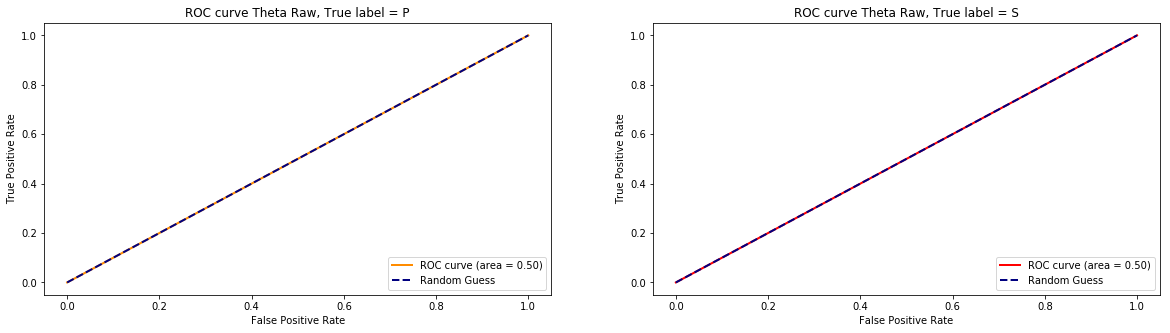

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0
StDev,0.0,1.110223e-16,0.0,0.0,0.0,0.0,0.0
Test,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0


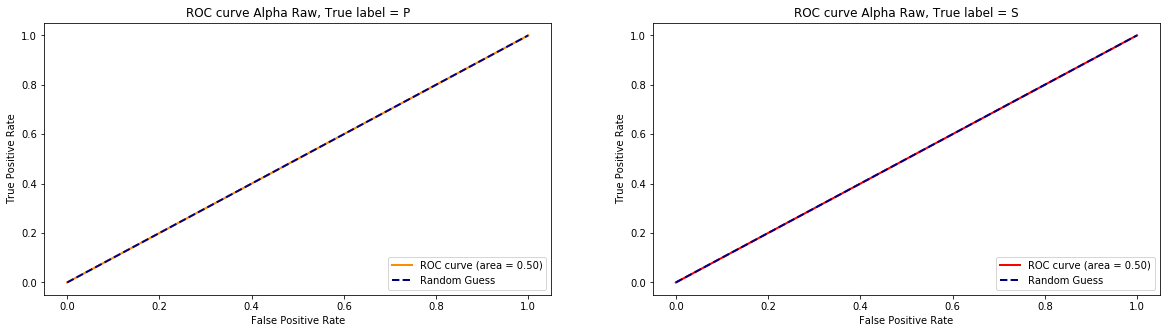

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0
StDev,0.0,1.110223e-16,0.0,0.0,0.0,0.0,0.0
Test,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0


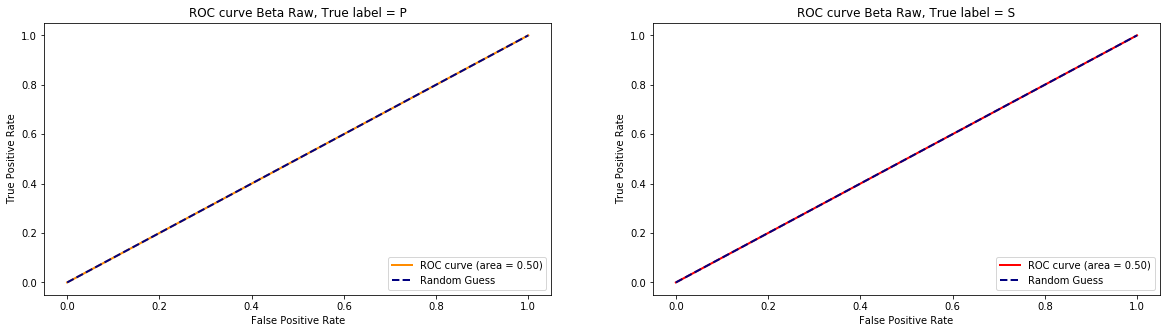

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0
StDev,0.0,1.110223e-16,0.0,0.0,0.0,0.0,0.0
Test,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0


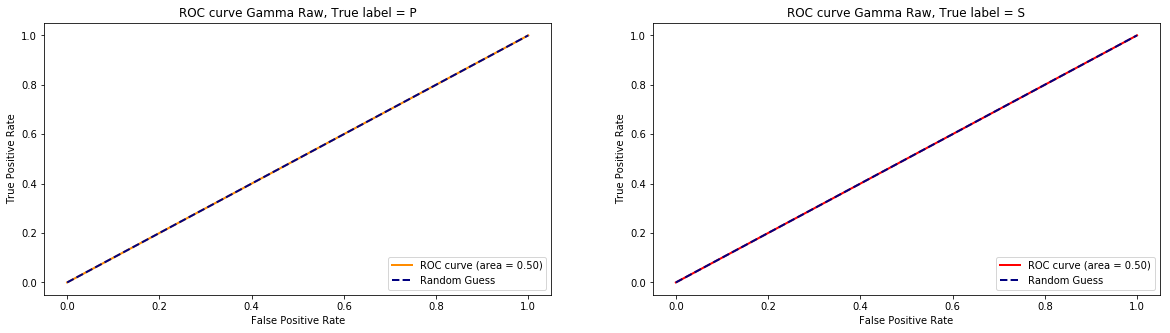

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0
StDev,0.0,1.110223e-16,0.0,0.0,0.0,0.0,0.0
Test,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0


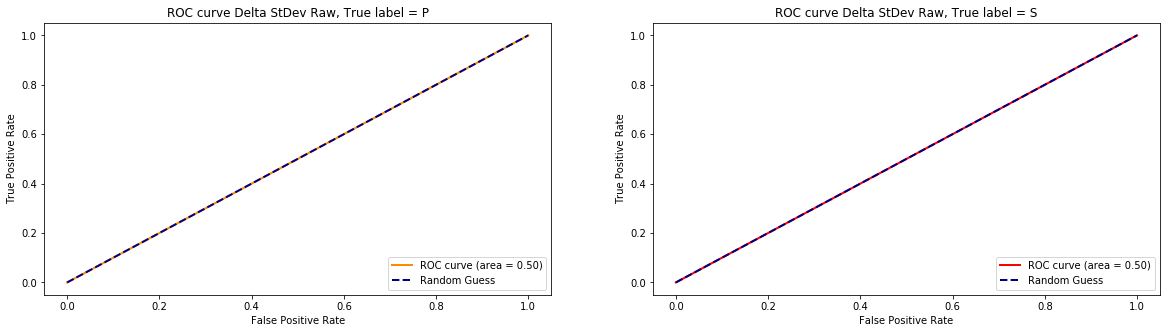

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0
StDev,0.0,1.110223e-16,0.0,0.0,0.0,0.0,0.0
Test,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0


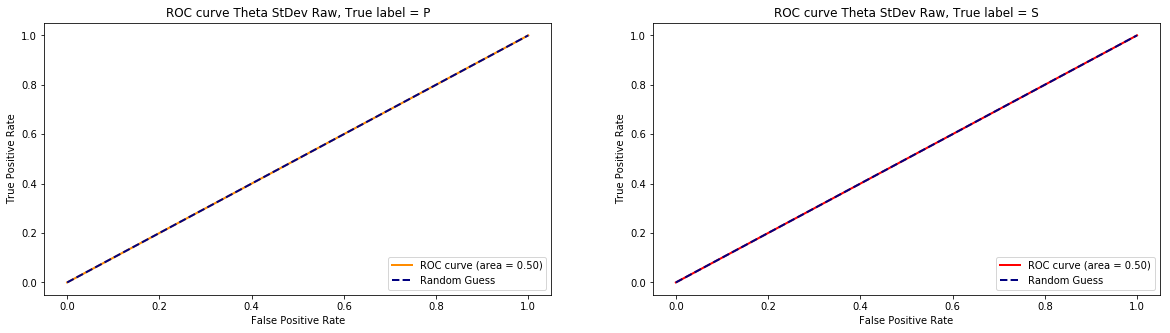

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0
StDev,0.0,1.110223e-16,0.0,0.0,0.0,0.0,0.0
Test,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0


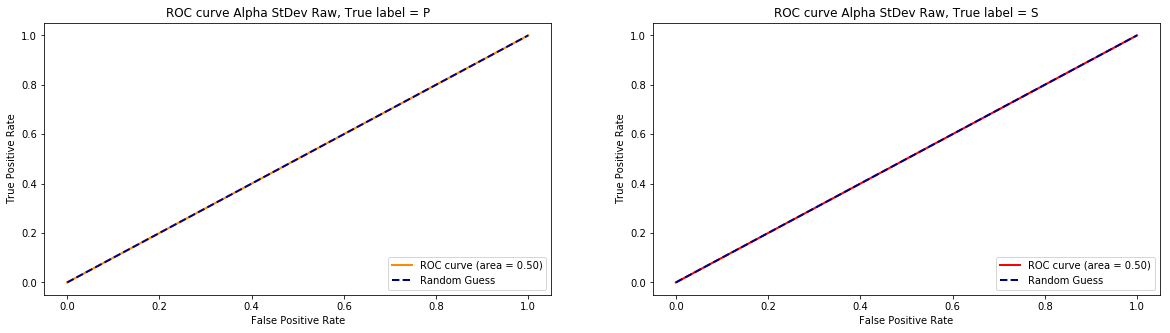

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0
StDev,0.0,1.110223e-16,0.0,0.0,0.0,0.0,0.0
Test,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0


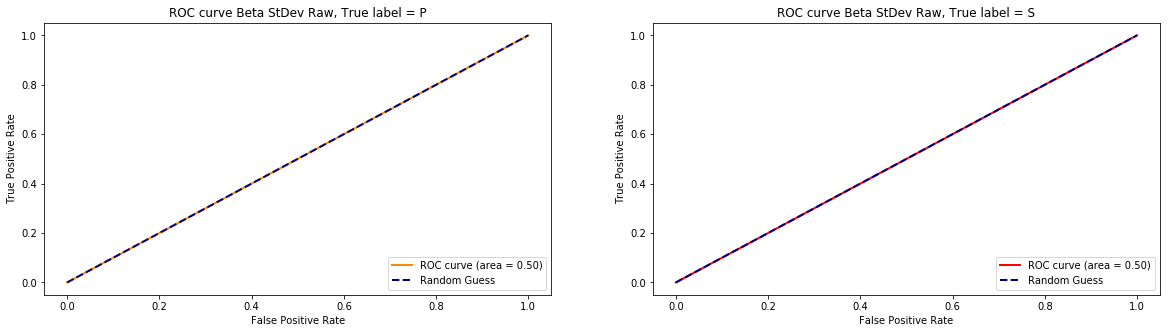

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0
StDev,0.0,1.110223e-16,0.0,0.0,0.0,0.0,0.0
Test,0.5,6.666667e-01,0.0,0.5,0.0,1.0,0.0


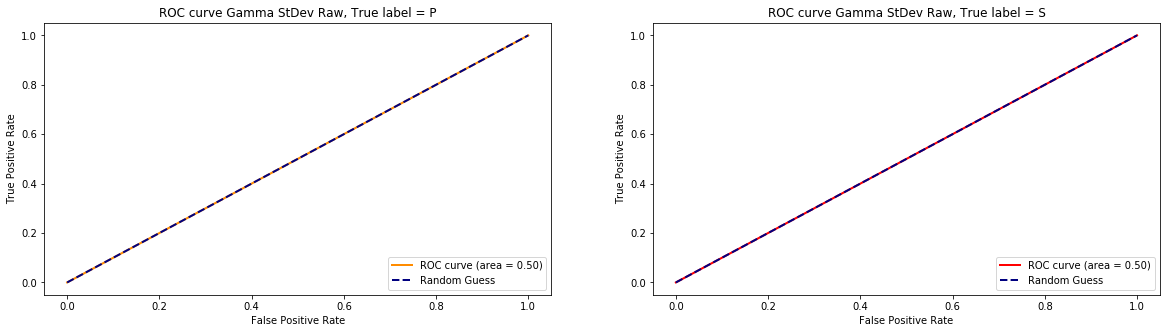

In [10]:
univariate1b(raw)


### Features: Mean and StDev para cada Banda de frecuencias para los datos normalizados

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.595000,0.674667,0.405333,0.586667,0.526667,0.840000,0.350000
StDev,0.205487,0.167539,0.346690,0.180247,0.458694,0.233238,0.320156
Test,0.250000,0.000000,0.400000,0.000000,0.333333,0.000000,0.500000


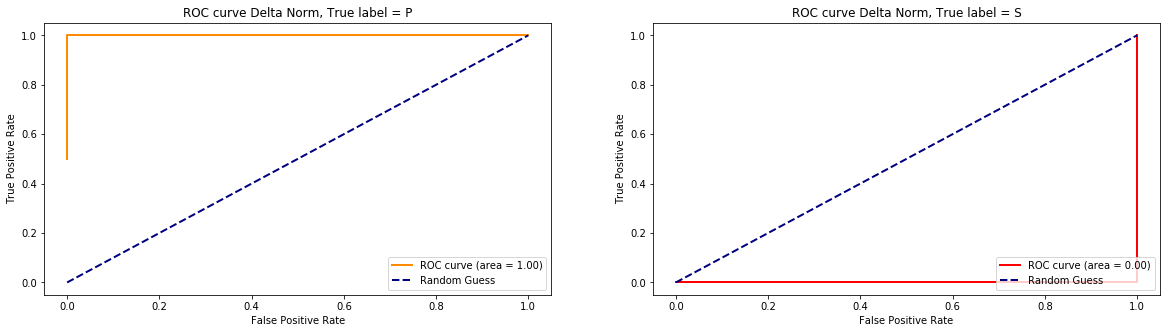

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.375000,0.364000,0.278667,0.330000,0.273333,0.440000,0.310000
StDev,0.195256,0.272588,0.272744,0.263502,0.292043,0.355528,0.314484
Test,0.500000,0.666667,0.000000,0.500000,0.000000,1.000000,0.000000


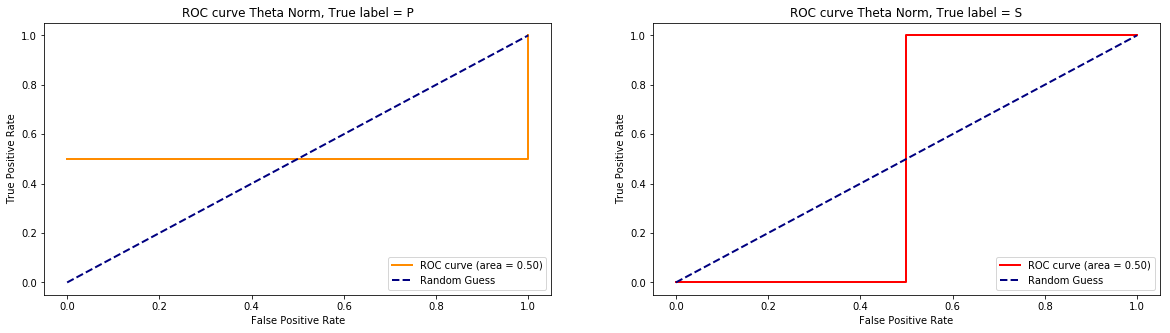

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.495000,0.553333,0.329333,0.490000,0.373333,0.670000,0.320000
StDev,0.220737,0.223408,0.336494,0.217077,0.399388,0.293428,0.342929
Test,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


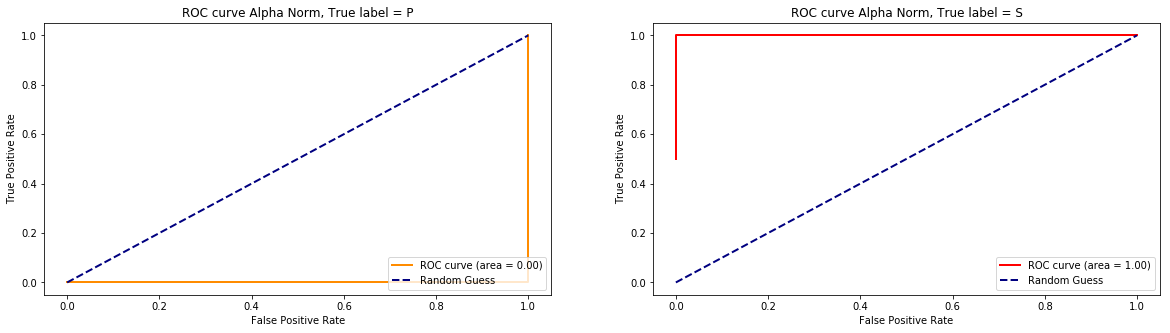

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.670000,0.713333,0.5560,0.663333,0.700000,0.840000,0.5
StDev,0.161555,0.142517,0.2846,0.181016,0.378594,0.233238,0.3
Test,0.500000,0.500000,0.5000,0.500000,0.500000,0.500000,0.5


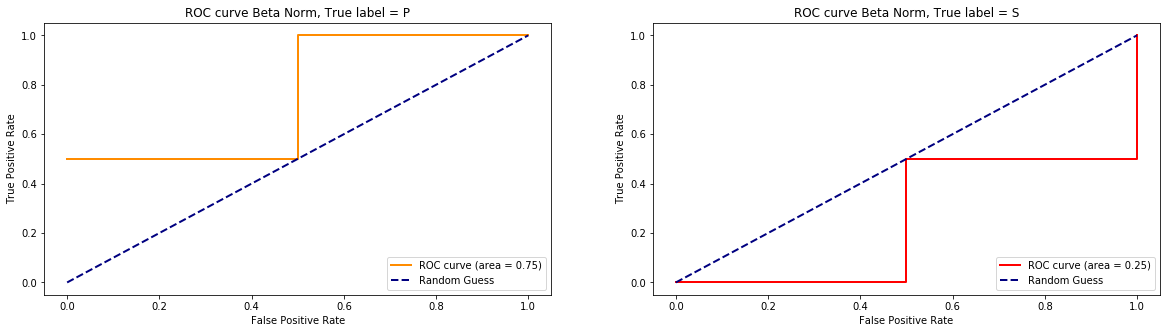

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.525,0.56200,0.354000,0.470000,0.453333,0.73,0.320000
StDev,0.225,0.29341,0.318879,0.257531,0.443521,0.39,0.295973
Test,0.250,0.40000,0.000000,0.333333,0.000000,0.50,0.000000


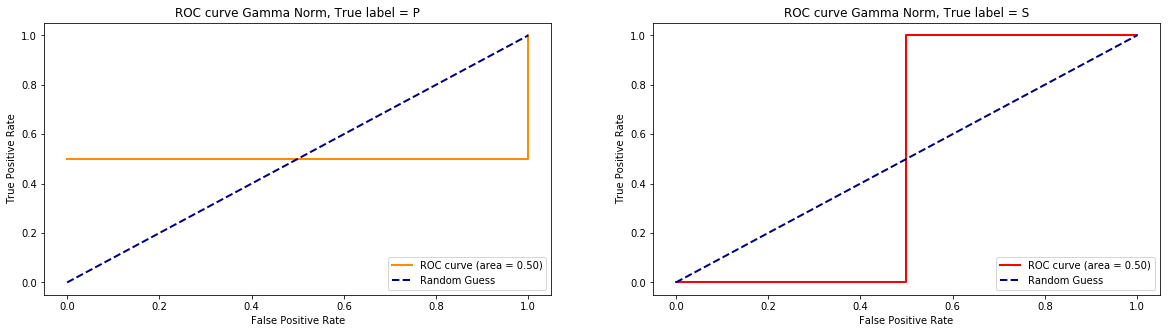

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.525,0.534667,0.433333,0.523333,0.473333,0.610000,0.440000
StDev,0.275,0.309477,0.346282,0.336667,0.401884,0.378021,0.369324
Test,0.500,0.666667,0.000000,0.500000,0.000000,1.000000,0.000000


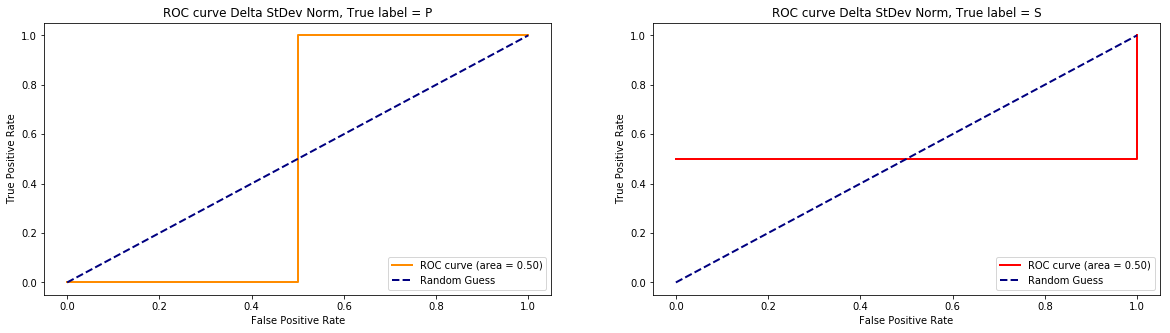

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.650000,0.597333,0.610667,0.596667,0.660000,0.660000,0.64000
StDev,0.180278,0.296561,0.252317,0.321611,0.316157,0.366606,0.31686
Test,0.250000,0.400000,0.000000,0.333333,0.000000,0.500000,0.00000


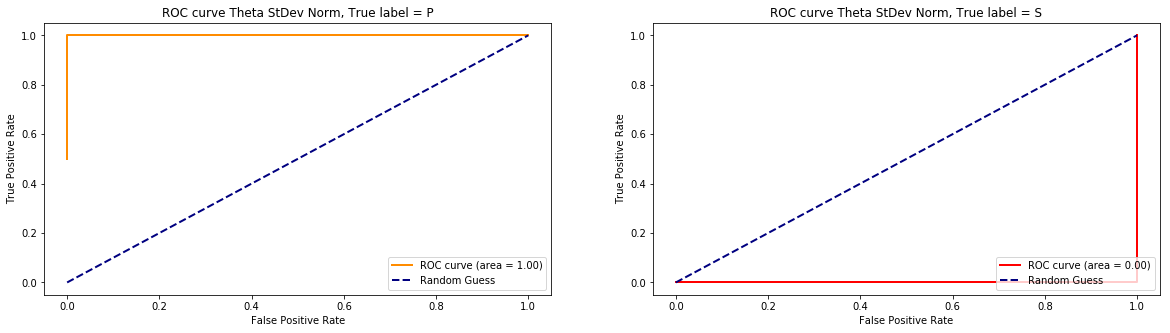

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.685,0.682667,0.624000,0.696667,0.660000,0.730000,0.640000
StDev,0.205,0.229806,0.304123,0.270165,0.338231,0.286531,0.346987
Test,0.500,0.666667,0.000000,0.500000,0.000000,1.000000,0.000000


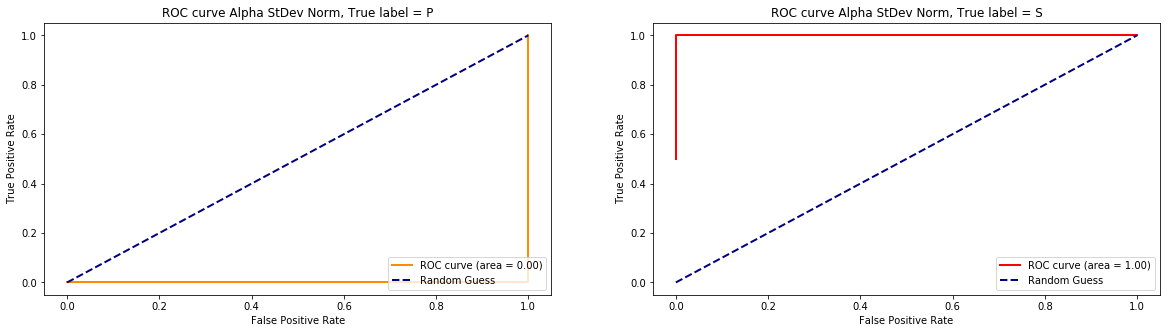

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.495000,0.533333,0.349333,0.480000,0.420000,0.66,0.33
StDev,0.237118,0.277449,0.312285,0.272111,0.409932,0.38,0.31
Test,0.500000,0.500000,0.500000,0.500000,0.500000,0.50,0.50


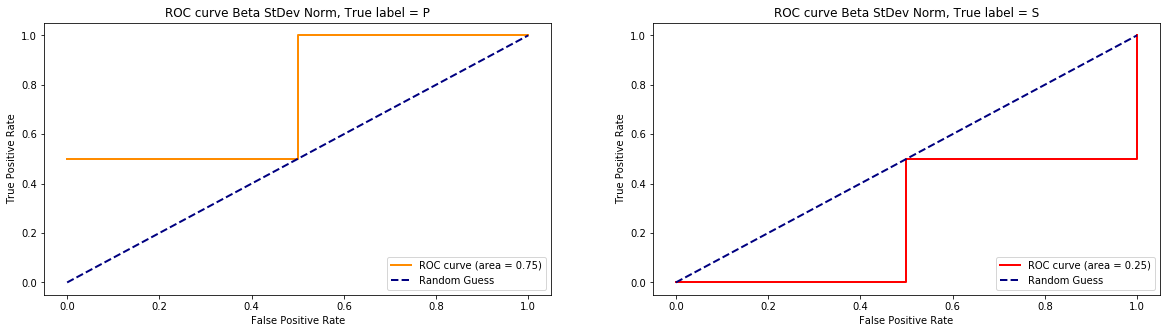

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.485000,0.512667,0.347333,0.443333,0.413333,0.640000,0.330000
StDev,0.196278,0.262965,0.286208,0.230000,0.389073,0.361109,0.275862
Test,0.500000,0.666667,0.000000,0.500000,0.000000,1.000000,0.000000


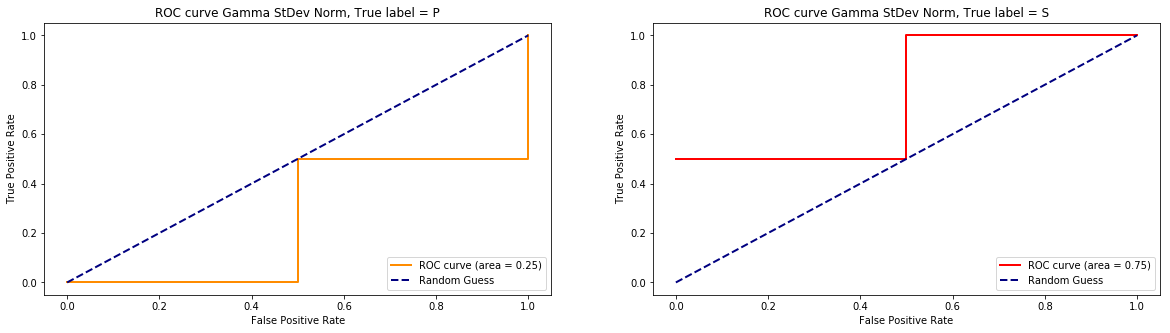

In [11]:
univariate1b(norm)


### Features: Mean and StDev para la medida intra-electrodo (entropía)

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.440000,0.350667,0.454667,0.363333,0.426667,0.360000,0.520000
StDev,0.209523,0.282626,0.247365,0.315683,0.247566,0.300666,0.315595
Test,0.500000,0.000000,0.666667,0.000000,0.500000,0.000000,1.000000


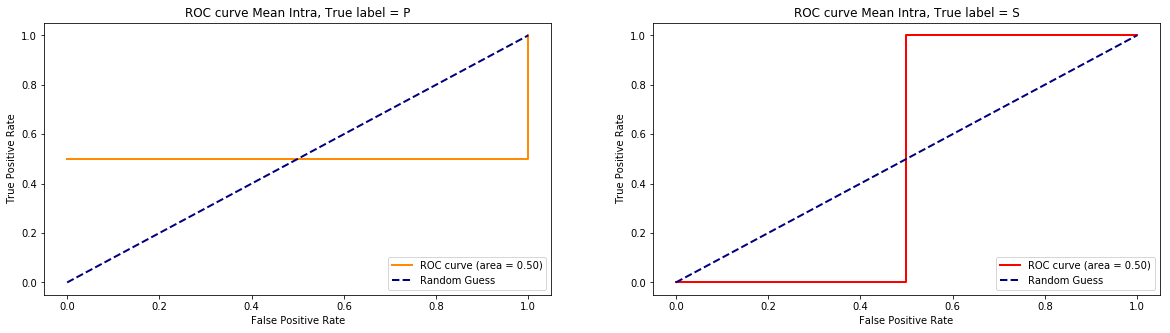

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.705000,0.500000,0.785333,0.680000,0.660000,0.410000,1.0
StDev,0.163478,0.360555,0.105232,0.466476,0.156205,0.326956,0.0
Test,0.750000,0.666667,0.800000,1.000000,0.666667,0.500000,1.0


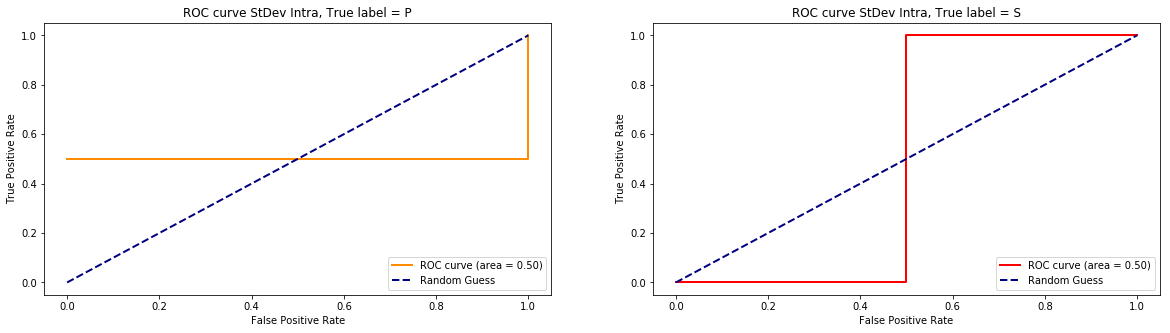

In [12]:
univariate1b(intra)


### Features: Mean and StDev para la medida inter-electrodo (entropía conjunta)

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.675000,0.536000,0.736000,0.693333,0.646667,0.460000,0.890000
StDev,0.201556,0.329905,0.168238,0.422111,0.184511,0.313688,0.207123
Test,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


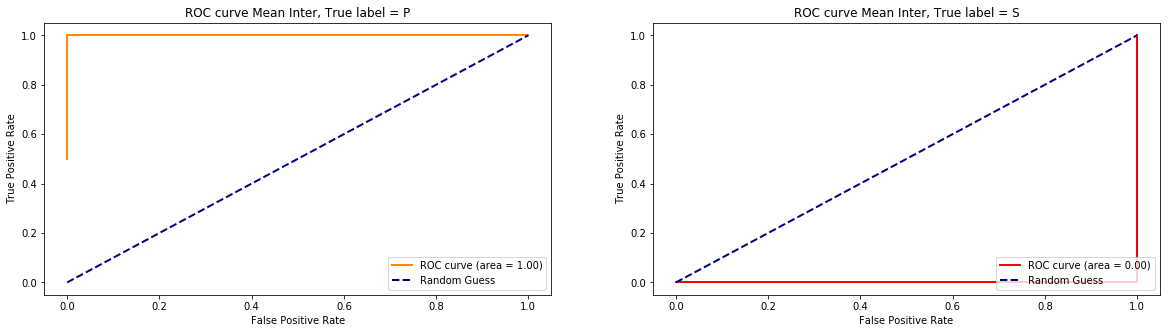

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.715000,0.658667,0.706667,0.706667,0.716667,0.670000,0.760000
StDev,0.206216,0.298333,0.248730,0.335923,0.283333,0.340735,0.303974
Test,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


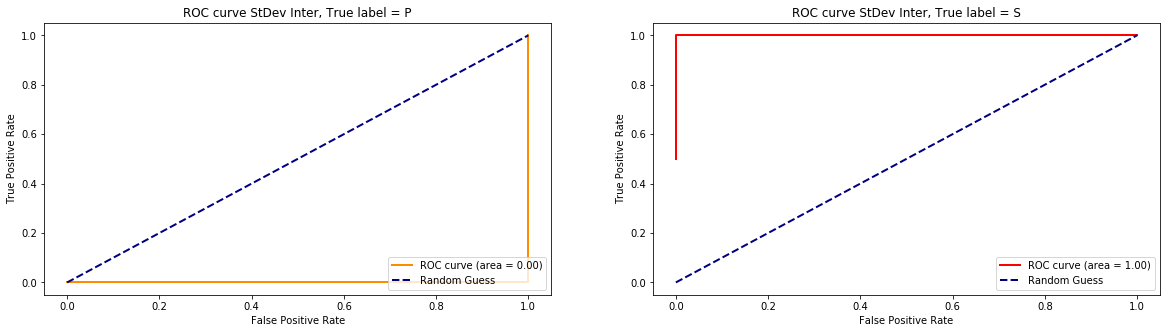

In [13]:
univariate1b(inter)


### ¿Cuál es su conclusión respecto a los resultados obtenidos en el punto anterior?

### Utilizar todos los features y entrenar un clasificador basado en Support Vector Machine. Computar la curva roc y graficarla. No olvidar reportar el area bajo la curva.

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.500000,0.458667,0.416000,0.446667,0.413333,0.530000,0.470000
StDev,0.173205,0.270683,0.293957,0.298961,0.321870,0.352278,0.366197
Test,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000


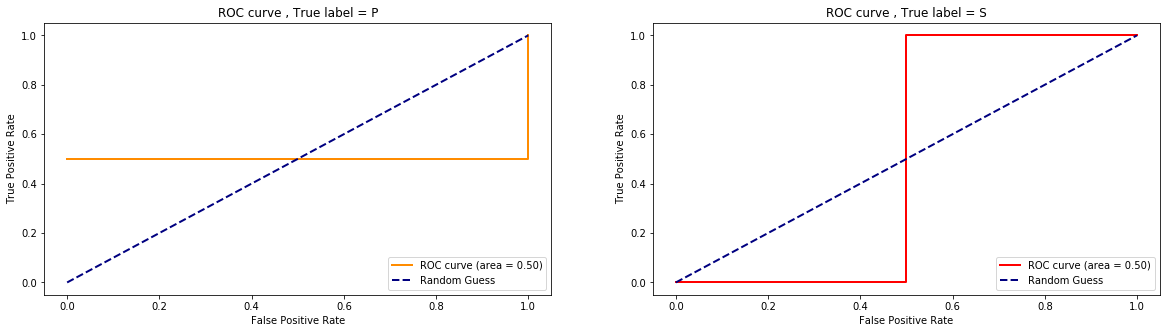

In [14]:
multivariate2a()


### Repetir, pero utilizando un pipeline de Scikit-Learn con los siguientes 3 pasos:

1. Standard Scaler
2. Feature Selection utilizando solo el 10%.
3. SVC

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.615000,0.644667,0.500667,0.610000,0.586667,0.750000,0.480000
StDev,0.213366,0.226824,0.324721,0.253004,0.401719,0.304138,0.345832
Test,0.750000,0.666667,0.800000,1.000000,0.666667,0.500000,1.000000


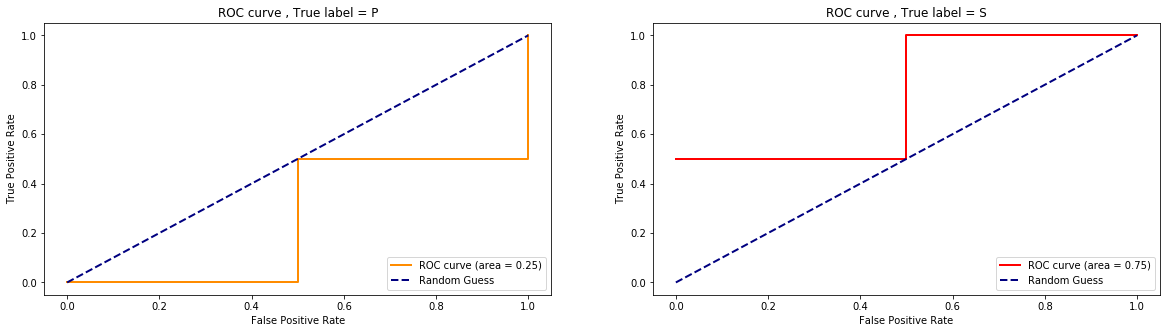

In [15]:
multivariate2b(10, 'linear')


### ¿Qué diferencia encuentra?

### ¿Y si utilizamos el 20% de los features?

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.575000,0.578667,0.490667,0.566667,0.560000,0.66000,0.490000
StDev,0.188746,0.233215,0.281349,0.266667,0.363257,0.32311,0.323883
Test,0.750000,0.800000,0.666667,0.666667,1.000000,1.00000,0.500000


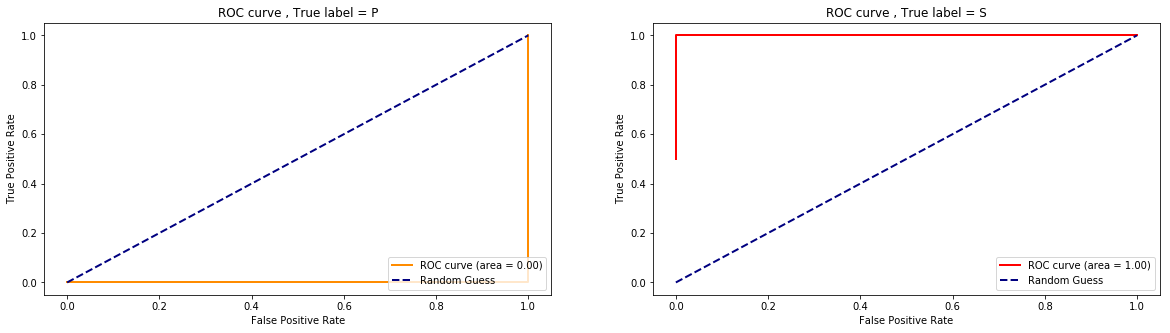

In [16]:
multivariate2b(20, 'linear')


### ¿Qué pasa si probamos y encontramos que utilizando el 35% de los features obtenemos la mejor AUC?

,Accuracy,F1 P,F1 S,Precision P,Precision S,Recall P,Recall S
Mean,0.550000,0.538667,0.472000,0.503333,0.533333,0.630000,0.470000
StDev,0.212132,0.289164,0.284516,0.289617,0.366667,0.371618,0.306757
Test,0.750000,0.800000,0.666667,0.666667,1.000000,1.000000,0.500000


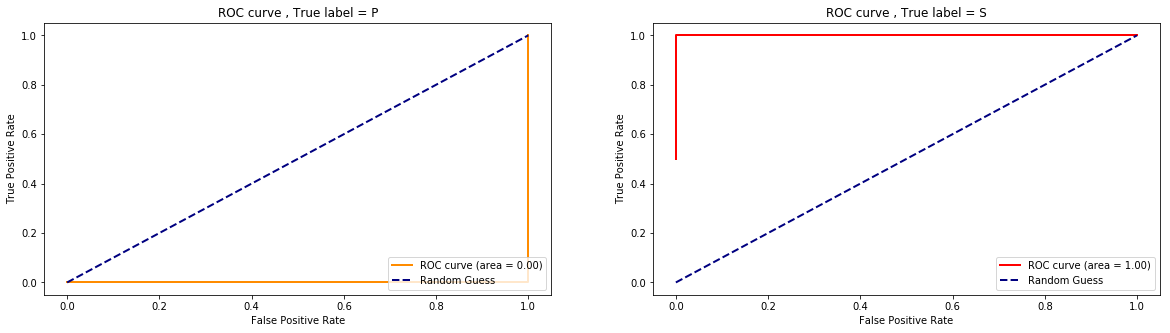

In [17]:
multivariate2b(35, 'linear')
